In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spsp
import matplotlib.pyplot as plt
from PIL import Image

In [11]:
# Diffusion function
g = lambda s: 1/(1+s)
g_exp = lambda s: np.exp(-s**2)

f = lambda x, y: x + y

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def image_display(V, n, m, cmap = "gray"):
    image = V.reshape((n, m))
    plt.imshow(image, cmap)
    plt.show()

def generate_squares2D(N, M):
    I = np.zeros((N+2, M+2))
    I[:N//2+1, :M//2+1] = 80
    I[:N//2+1, -(M//2+1):] = 190
    I[-(N//2+1):, :M//2+1] = 140
    I[-(N//2+1):, -(M//2+1):] = 230
    return I

def add_noise2D(I, scale = 10):
    N, M = I.shape
    N -= 2
    M -= 2
    I[1:-1, 1:-1] += np.random.rand(N,M) * scale
    return I
    
def generate_random2D(N, M, scale = 10):
    I = generate_squares2D(N, M)
    add_noise2D(I)
    return I

def diffX(M, N, scheme = "central"):
    K = (M+2)*(N+2)
    Dx = np.zeros((K, K))
    dx = 1/(M+1)
    
    if scheme == "central":
        Bx = (-1 * np.eye(M+2, k = -1) + np.eye(M+2, k = 1))
        Bx[0, :3] = [-3, 4, -1]
        Bx[-1, -3:] = [1, -4, 3]
        Bx /= (2*dx)
        
    elif scheme == "forward":
        Bx = (-1 * np.eye(M+2) + np.eye(M+2, k = 1))
        Bx[-1, -2:] = [-1, 1]
        Bx /= dx
    else:
        raise Exception("Invalid scheme in Dx")    
        
    for i in range(N+2):
        Dx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Bx

    return Dx

def diffY(M, N, scheme = "central"):
    K = (M+2)*(N+2)
    Dy = np.zeros((K, K))
    dy = 1/(N+1)
    
    if scheme == "central":
        Dy = -np.eye(K, k = -(M+2)) + np.eye(K, k = M+2)
        Dy[:(M+2), :3*(M+2)] = np.hstack((-3*np.identity(M+2), 4*np.identity(M+2), -np.identity(M+2)))
        Dy[-(M+2):, -3*(M+2):] = np.hstack((np.identity(M+2), -4*np.identity(M+2), 3*np.identity(M+2)))
        Dy /= 2*dy
        
    elif scheme == "forward":
        Dy = -np.eye(K) + np.eye(K, k = M+2)
        Dy[:(M+2), :2*(M+2)] = np.hstack((-np.identity(M+2), np.identity(M+2)))
        Dy[-(M+2):, -2*(M+2):] = np.hstack((-np.identity(M+2), np.identity(M+2)))
        Dy /= dy
        
    else:
        raise Exception("Invalid scheme in Dy")
    
    return Dy  

def support_matrices_X(M, N):
    K = (M+2)*(N+2)
    
    Ξx = np.zeros((K, K))
    Ωx = np.zeros((K, K))
    Γx = np.zeros((K, K))
    
    #Block matrix for Ξx
    Xx = np.eye(M+2, k = -1) + np.eye(M+2)
    Xx[0, :2] = 0
    Xx[-1, -2:] = 0

    #Block matrix for Ωx
    Mx = -np.eye(M+2, k = -1) -2*np.eye(M+2) - np.eye(M+2, k = 1)
    Mx[0, :2] = 0
    Mx[-1, -2:] = 0

    #Block matrix for Γx
    Fx = np.eye(M+2) + np.eye(M+2, k = 1)
    Fx[0, :2] = 0
    Fx[-1, -2:] = 0
    
    # Fill in matrices
    for i in range(1, N+1):
        Ξx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Xx

    for i in range(1, N+1):
        Ωx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Mx

    for i in range(1, N+1):
        Γx[i*(M+2):(i+1)*(M+2), i*(M+2):(i+1)*(M+2)] = Fx

    return Ξx, Ωx, Γx

def support_matrices_Y(M, N):
    K = (M+2)*(N+2)
    Ξy = np.zeros((K, K))
    Ωy = np.zeros((K, K))
    Γy = np.zeros((K, K))
    
    for i in range(1, N+1):
        Ξy[i*(M+2)+1:(i+1)*(M+2)-1, (i-1)*(M+2)+1:i*(M+2)-1] = np.identity(M)
        Ξy[i*(M+2)+1:(i+1)*(M+2)-1, i*(M+2)+1:(i+1)*(M+2)-1] = np.identity(M)

    for i in range(1, N+1):
        Ωy[i*(M+2)+1:(i+1)*(M+2)-1, (i-1)*(M+2)+1:i*(M+2)-1] = -np.identity(M)
        Ωy[i*(M+2)+1:(i+1)*(M+2)-1, i*(M+2)+1:(i+1)*(M+2)-1] = -2*np.identity(M)
        Ωy[i*(M+2)+1:(i+1)*(M+2)-1, (i+1)*(M+2)+1:(i+2)*(M+2)-1] = -np.identity(M)

    for i in range(1, N+1):
        Γy[i*(M+2)+1:(i+1)*(M+2)-1, i*(M+2)+1:(i+1)*(M+2)-1] = np.identity(M)
        Γy[i*(M+2)+1:(i+1)*(M+2)-1, (i+1)*(M+2)+1:(i+2)*(M+2)-1] = np.identity(M)
    
    return Ξy, Ωy, Γy

def assemble_A(u, M, N, g, Dx, Dy, Ξx, Ωx, Γx, Ξy, Ωy, Γy):
    dx = 1/(M+1)
    dy = 1/(N+1)
    G = g(Dx.dot(u)**2 + Dy.dot(u)**2)
    
    ξx = Ξx.dot(G)
    ωx = Ωx.dot(G)
    γx = Γx.dot(G)

    ξy = Ξy.dot(G)
    ωy = Ωy.dot(G)
    γy = Γy.dot(G)
    
    x_diags = (ξx[1:], ωx, γx[:-1])
    y_diags = (ξy[(M+2):], ωy, γy[:-(M+2)])
    Ax = spsp.diags(x_diags, (-1, 0, 1))/(2*dx**2)
    Ay = spsp.diags(y_diags, (-(M+2), 0, M+2))/(2*dy**2)
    A = Ax+ Ay
    return A.toarray()


def polsk_dirichlet_explicit(u0, M, N, T, dt):
    g = lambda s: 1/(1+s**2)
    dx = 1/(M+1)
    dy = 1/(N+1)
    r = 1/2 * (dt/(dx**2 + dy**2))
    
    U = np.zeros((T, K))
    U[0] = u0   
    
    Dx = diffX(M, N)
    Dy = diffY(M, N)
    
    Ξx, Ωx, Γx = support_matrices_X(M, N)
    Ξy, Ωy, Γy = support_matrices_Y(M, N)
    
    for it in range(T-1):
        A = assemble_A(U[it], M, N, g, Dx, Dy, Ξx, Ωx, Γx, Ξy, Ωy, Γy)
        G = g(Dx.dot(U[it])**2 + Dy.dot(U[it])**2)
        U[it+1] = U[it]  + r * A.dot(U[it])
        
        if it % (T//50) == 0:
            iteration_echo(M, N, G, A, Dy, Dx, U[it])            
    return U

def polsk_dirichlet_implicit(u0, M, N, T, dt):
    dx = 1/(M+1)
    dy = 1/(N+1)
    r = 1/2 * (dt/(dx**2 + dy**2))
    

    U = np.zeros((T, K))
    U[0] = u0   
    
    Dx = diffX(M, N)
    Dy = diffY(M, N)
    
    Ξx, Ωx, Γx = support_matrices_X(M, N)
    Ξy, Ωy, Γy = support_matrices_Y(M, N)

    for it in range(T-1):
        A = assemble_A(U[it], M, N, g, Dx, Dy, Ξx, Ωx, Γx, Ξy, Ωy, Γy)
        G = g(Dx.dot(U[it])**2 + Dy.dot(U[it])**2)
        
        U[it+1] = np.linalg.solve(np.identity((M+2)*(N+2)) - r * A, U[it])
        
        if it % (T//100) == 0:
            iteration_echo(M, N, G, A, Dy, Dx, U[it])            

    return U

def iteration_echo(M, N, G, A, Dy, Dx, u):
    K = (M+2)*(N+2)
    plt.figure(figsize=(12, 8))
    plt.subplot(141)
    plt.imshow(u.reshape(N+2, M+2), cmap = "gray", vmin = 0, vmax = 255)
    
    plt.subplot(142)
    plt.imshow(A.dot(u).reshape(N+2, M+2), cmap = "gray")

    plt.subplot(143)
    plt.imshow((Dy.dot(u)**2 + Dx.dot(u)**2).reshape(N+2, M+2), cmap = "gray")
    
    plt.subplot(144)
    plt.imshow(G.reshape(N+2, M+2), cmap = "gray", vmax = 5e-2)

    plt.show()

In [ ]:
# Spatial discretization
M = 62
N = 62
K = (M+2) * (N+2)
dx = 1/(M+1)
dy = 1/(N+1)

# Initial conditions
# I = generate_random2D(N, M, scale = 2)
I = load_image("lena-64x64.jpg") + np.random.randint(0, 20, (M+2, N+2))

# Number of iterations, and timestep
T = 1000
dt = 5e-4
r = dt/(2*(dx**2 + dy**2))

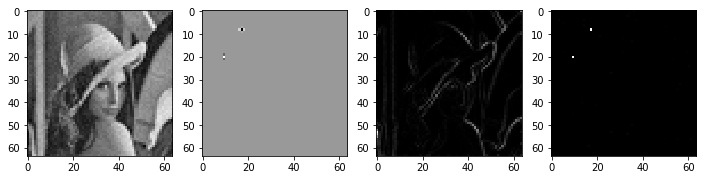

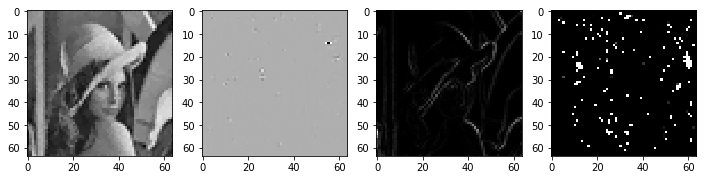

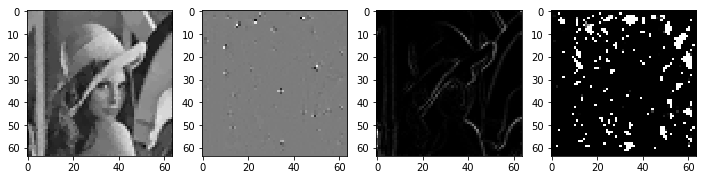

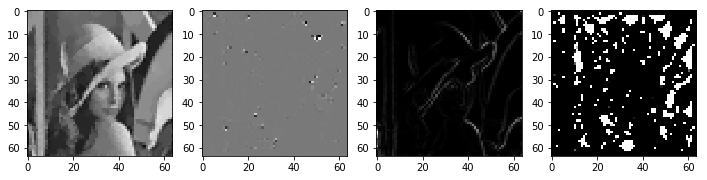

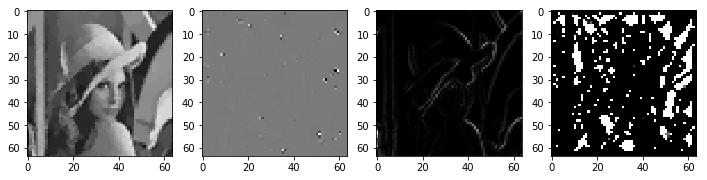

In [ ]:
U = polsk_dirichlet_implicit(I.reshape(K), M, N, T, dt)